<a href="https://colab.research.google.com/github/Omega-84/NLP-RNN_LSTM/blob/master/NLP_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
import string
import re
import nltk
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metric
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
import gensim
from google.colab import drive
drive.mount('/content/drive')
plt.style.use('ggplot')
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv("/content/drive/MyDrive/Advance NLP/spam.csv",encoding='latin-1')
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
df.rename(columns={'v2':'Text','v1':'Label'},inplace=True)
pd.set_option('display.max_colwidth',100)
df['Label'] = np.where(df['Label']=='spam',1,0)

In [3]:
df.head()

,Label,Text
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives around here though"


In [4]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def text_clean(text):
  '''
  Clean the message text and tokenize the message
  '''
  text = "".join([char.lower() for char in text if char not in string.punctuation])
  tokens = re.split('\W+',text)
  text = [word for word in tokens if word not in stopwords]
  return text

In [6]:
df['Text_token'] = df['Text'].apply(text_clean)
df['Cleaned_text'] = df['Text'].apply(lambda x : " ".join(text_clean(x)))

In [7]:
df.head()

,Label,Text,Text_token,Cleaned_text
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...","[go, jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat]",go jurong point crazy available bugis n great world la e buffet cine got amore wat
1,0,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]",ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,"[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, 87121, receiv...",free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questions...
3,0,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]",u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives around here though","[nah, dont, think, goes, usf, lives, around, though]",nah dont think goes usf lives around though


#TF-IDF

In [8]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Cleaned_text'])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), df['Label'], test_size=0.2, stratify=df['Label'],random_state=42)

In [10]:
rf_clf = RandomForestClassifier()

In [11]:
rf_clf.fit(X_train,y_train)

RandomForestClassifier()

In [12]:
y_pred = rf_clf.predict(X_test)

In [13]:
metric.accuracy_score(y_test,y_pred)

0.9730941704035875

In [14]:
metric.precision_score(y_test,y_pred)

1.0

In [15]:
metric.recall_score(y_test,y_pred)

0.7986577181208053

In [16]:
print(metric.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       1.00      0.80      0.89       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



#Word2Vec

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df['Text_token'], df['Label'], test_size=0.2, stratify=df['Label'], random_state=42)

In [18]:
w2v = gensim.models.Word2Vec(X_train,window=8,size=100,min_count=3)

In [19]:
w2v.train(X_train,total_examples=w2v.corpus_count, epochs=w2v.epochs)

(155774, 211665)

#LSTM

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Label'], test_size=0.2, stratify=df['Label'], random_state=42)

In [21]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)

In [22]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [23]:
X_train_pad = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq,50)
X_test_pad = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq,50)

In [24]:
def recall_m(y_true,y_pred):
    true_pos = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true*y_pred,0,1)))
    possible_pos = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true,0,1)))
    recall = true_pos / (possible_pos + tf.keras.backend.epsilon())
    return recall
def precision_m(y_true,y_pred):
    true_pos = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true*y_pred,0,1)))
    predicted_pos = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred,0,1)))
    precision = true_pos / (predicted_pos + tf.keras.backend.epsilon())
    return precision

In [25]:
input_dim = len(tokenizer.index_word) + 1
input_dim

7919

In [26]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim,32),
                             tf.keras.layers.LSTM(32),
                             tf.keras.layers.Dense(32,activation='relu'),     
                             tf.keras.layers.Dense(16,activation='relu'),
                             tf.keras.layers.Dense(1,activation='sigmoid')
                             ])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          253408    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 263,329
Trainable params: 263,329
Non-trainable params: 0
_________________________________________________________________


In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 2)

In [29]:
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy',recall_m,precision_m])

In [30]:
network = model.fit(X_train_pad,y_train,
                    batch_size = 32,
                    epochs = 10,
                    steps_per_epoch=200,
                    validation_data = (X_test_pad,y_test),
                    callbacks = [early_stopping]
                    )

Epoch 1/10
200/200 [==============================] - 7s 19ms/step - loss: 0.1937 - accuracy: 0.9348 - recall_m: 0.5584 - precision_m: 0.6013 - val_loss: 0.0577 - val_accuracy: 0.9865 - val_recall_m: 0.9179 - val_precision_m: 0.9943
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0190 - accuracy: 0.9948 - recall_m: 0.9671 - precision_m: 0.9889 - val_loss: 0.0506 - val_accuracy: 0.9874 - val_recall_m: 0.9307 - val_precision_m: 0.9871
Epoch 3/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0070 - accuracy: 0.9981 - recall_m: 0.9661 - precision_m: 0.9698 - val_loss: 0.0570 - val_accuracy: 0.9874 - val_recall_m: 0.9379 - val_precision_m: 0.9824
Epoch 4/10
200/200 [==============================] - 3s 17ms/step - loss: 3.2642e-04 - accuracy: 1.0000 - recall_m: 0.9850 - precision_m: 0.9850 - val_loss: 0.0716 - val_accuracy: 0.9874 - val_recall_m: 0.9307 - val_precision_m: 0.9881


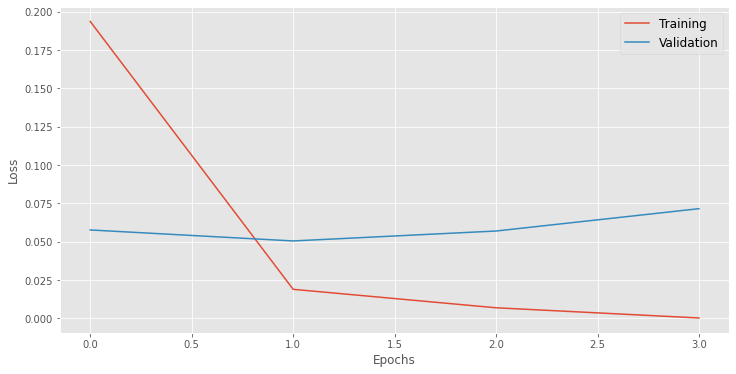

In [31]:
plt.figure(figsize=(12,6))
plt.plot(network.history['loss'],label = 'Training')
plt.plot(network.history['val_loss'],label = 'Validation')
plt.legend(loc='best',fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Loss");

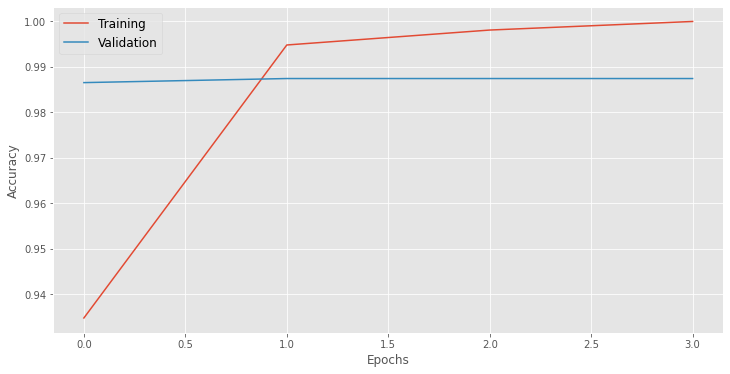

In [32]:
plt.figure(figsize=(12,6))
plt.plot(network.history['accuracy'],label = 'Training')
plt.plot(network.history['val_accuracy'],label = 'Validation')
plt.legend(loc='best',fontsize=12)
plt.xlabel("Epochs")
plt.ylabel("Accuracy");